In [1]:
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import pandas as pd
import os
import torch
import copy
from tqdm import tqdm
from metrics import evaluation_metrics

from slim import SLIMDataModule

# Instantiate the DataModule

data_module = SLIMDataModule(data_dir="./data")

Lol


In [5]:
import matplotlib.pyplot as plt

train_dataloader = data_module.train_dataloader()
# Get first batch
batch = next(iter(train_dataloader))
# Visualise the images

In [6]:
batch[0].shape

torch.Size([32, 112, 112])

In [34]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def train_model(
    model,
    train_dataloader,
    val_dataloader,
    num_epochs=100,
    lr=0.01,
    validate_every=1,
    patience=10,
    criterion=None,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    train_dataloader : torch.utils.data.DataLoader
        DataLoader for the training set.
    val_dataloader : torch.utils.data.DataLoader
        DataLoader for the validation set.
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    validate_every : int
        Validate (and possibly checkpoint) every 'validate_every' epochs.
    patience : int
        Patience for learning rate scheduler.
    criterion : torch.nn.Module
        Loss function.

    Returns:
    --------
    best_loss_history : list
        The training loss history across epochs.
    best_model_state_dict : dict
        The state dictionary of the model achieving the best validation accuracy.
    """

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=patience
    )
    train_loss_history = []
    val_loss_history = []

    best_val_loss = torch.inf
    best_model_state_dict = None
    val_loss = 0.0

    progress_bar = tqdm(range(num_epochs))
    for epoch in progress_bar:
        progress_bar.set_description(f"Epoch {epoch}|{num_epochs}")
        model.train()
        epoch_loss = 0.0

        for batch in train_dataloader:
            inputs, targets = batch
            optimizer.zero_grad()

            # Forward pass on training data
            outputs = model(inputs)
            loss = criterion(outputs, targets.to(model.device))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Record training loss
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_dataloader)
        train_loss_history.append(avg_loss)

        # Validation step
        if (epoch + 1) % validate_every == 0 or (epoch + 1) == num_epochs:
            model.eval()
            val_loss = 0.0
            for batch in val_dataloader:
                inputs, targets = batch
                outputs = model(inputs)

                val_loss += criterion(outputs, targets.to(model.device)).item()

            val_loss /= len(val_dataloader)
            val_loss_history.append(val_loss)
            scheduler.step(val_loss)

            lr = get_lr(optimizer)

            # Check if this is the best f1 score so far
            if val_loss > best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = copy.deepcopy(model.state_dict())

            if lr < 1e-5:
                break

        progress_bar.set_postfix({"train_loss": avg_loss, "val_loss": val_loss})

    # If we have a best model, load it
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return train_loss_history, val_loss_history, best_model_state_dict


@torch.no_grad()
def evaluate_model(model, dataloader, criterion):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    val_loss = 0.0
    eval_metrics = {
        "mae": 0,
        "pcc": 0,
        "js_dis": 0,
        "avg_mae_bc": 0,
        "avg_mae_ec": 0,
        "avg_mae_pc": 0,
    }

    for batch in dataloader:
        inputs, targets = batch
        inputs.to(model.device)
        outputs.to(model.device)
        outputs = model(inputs)

        val_loss += criterion(targets, outputs).item()
        batch_metrics = evaluation_metrics(
            outputs.detach().numpy(), targets.detach().numpy()
        )

        for k, v in batch_metrics.items():
            eval_metrics[k] += v

    val_loss /= len(dataloader)
    for v in eval_metrics.values():
        v /= len(dataloader)
    return val_loss, eval_metrics

In [35]:
# Naive MLP model
import torch
import torch.nn as nn
import numpy as np


class SuperResMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super().__init__()
        h = int(np.sqrt(output_size))
        self.layers = nn.ModuleList(
            [
                nn.Flatten(),
                nn.Linear(in_features=input_size, out_features=hidden_dim),
                nn.BatchNorm1d(num_features=hidden_dim),
                nn.Dropout(p=0.1),
                nn.ReLU(),
            ]
        )
        for _ in range(n_layers - 1):
            self.layers.append(
                nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
            )
            self.layers.append(nn.BatchNorm1d(num_features=hidden_dim))
            self.layers.append(nn.Dropout(p=0.1))
            self.layers.append(nn.ReLU())

        self.layers.append(nn.Linear(in_features=hidden_dim, out_features=output_size))
        self.layers.append(nn.Unflatten(dim=1, unflattened_size=(h, h)))

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, samples: torch.Tensor):
        # Flatten the input if it's a 2D matrix
        x = samples.to(self.device)
        for layer in self.layers:
            x = layer(x)

        return x

In [37]:
# Define the model, loss function, and optimizer
input_size = batch[0].shape[1] ** 2
output_size = batch[1].shape[1] ** 2
hidden_dim = 1000
n_layers = 3

model = SuperResMLP(input_size, output_size, hidden_dim, n_layers).to(
    torch.device("mps")
)
criterion = nn.MSELoss()


train_losses, val_losses, _ = train_model(
    model=model,
    train_dataloader=data_module.train_dataloader(),
    val_dataloader=data_module.val_dataloader(),
    num_epochs=100,
    lr=0.001,
    validate_every=1,
    patience=5,
    criterion=criterion,
)

Epoch 11|100:  11%|█         | 11/100 [01:01<08:19,  5.61s/it, train_loss=0.0513, val_loss=0.0368]


KeyboardInterrupt: 

In [20]:
def plot_loss(train_losses, val_losses, title="Losses"):
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

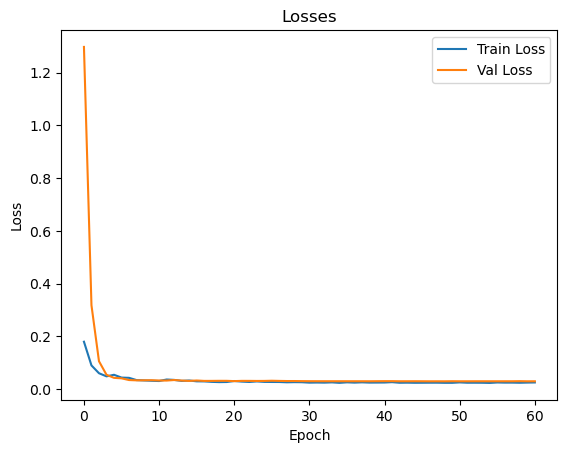

In [21]:
plot_loss(train_losses=train_losses, val_losses=val_losses)

In [22]:
## Evaluation metrics

_, eval_metrics = evaluate_model(
    model, data_module.val_dataloader(), criterion=criterion
)

print(eval_metrics)

{'mae': 0.2808445245027542, 'pcc': 1.2838559725815402, 'js_dis': inf, 'avg_mae_bc': 0.08812217397167334, 'avg_mae_ec': 0.03461966390943963, 'avg_mae_pc': 0.0015977102068784196}
